In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import pandas as pd
import tiktoken
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

load_dotenv()
EMBEDDING_MODEL = 'text-embedding-ada-002'
EMBEDDING_ENCODING = 'cl100k_base'
MAX_TOKEN = 8000

In [2]:
input_datapath = './archive/Reviews-01.csv'
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df.dropna()

df['combined'] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)

In [3]:
df.head()

,Time,ProductId,UserId,Score,Summary,Text,combined
Id,,,,,,,
1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...
3,1219017600,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all",This is a confection that has been around a fe...,"Title: ""Delight"" says it all; Content: This is..."
4,1307923200,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine,If you are looking for the secret ingredient i...,Title: Cough Medicine; Content: If you are loo...
5,1350777600,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy,Great taffy at a great price. There was a wid...,Title: Great taffy; Content: Great taffy at a ...


In [13]:
top_n = 1000
df = df.sort_values('Time').tail(top_n * 2)
df.drop('Time', axis=1, inplace=True)

In [14]:
encoding = tiktoken.get_encoding(EMBEDDING_ENCODING)

# Omit reviews that are too long to embed
df['n_tokens'] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= MAX_TOKEN].tail(top_n)
len(df)

1000

In [15]:
client = OpenAI()

In [22]:
def get_embedding(text, model=EMBEDDING_MODEL):
    text = text.replace('\n', ' ')
    return client.embeddings.create(input=[text],model=model).data[0].embedding

In [23]:
df['ada_embedding'] = df.combined.apply(lambda x: get_embedding(x, model=EMBEDDING_MODEL))

In [25]:
df.to_csv('output/embedded_1k_reviews.csv', index=False)

## Data visualization in 2D

1-star: red
2-star: dark orange
3-star: gold
4-star: turquoise
5-star: dark green

In [9]:
import numpy as np

df = pd.read_csv('./output/embedded_1k_reviews.csv')
matrix = np.array(df.ada_embedding.apply(eval).to_list())

In [10]:
matrix

array([[ 0.00299775, -0.01256449,  0.01776494, ..., -0.03018606,
         0.00559472, -0.02170112],
       [ 0.00040634,  0.00058854, -0.01663679, ..., -0.01105052,
        -0.01759947, -0.0222773 ],
       [-0.01057454, -0.00594652,  0.00692539, ..., -0.00260368,
        -0.01406388, -0.0298591 ],
       ...,
       [-0.03021241, -0.00780307, -0.01360639, ..., -0.02256472,
        -0.01145802, -0.0522907 ],
       [-0.00791268, -0.01345951,  0.00093441, ..., -0.01150453,
        -0.0125251 , -0.01298899],
       [ 0.00297048,  0.00573072,  0.0061066 , ..., -0.00974126,
        -0.00195112, -0.00321098]])

Create a t-SNE model and transform the data

In [11]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [13]:
vis_dims = tsne.fit_transform(matrix)

In [15]:
vis_dims.shape

(1000, 2)

Plotting the embeddings

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

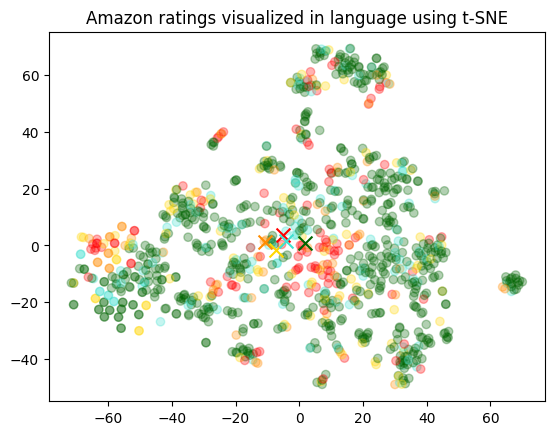

In [16]:
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

## Embedding as a text feature encoder for ML algorithms

An embedding can be used as a general free-text feature encoder within a machine learning model. Incorporating embeddings will improve the performance of any machine learning model, if some of the relevant inputs are free text. An embedding can also be used as a categorical feature encoder within a ML model. This adds most value if the names of categorical variables are meaningful and numerous, such as job titles. Similarity embeddings generally perform better than search embeddings for this task.

We're predicting the score of the review, which is a number between 1 and 5 (1-star being negative and 5-star positive).

In [19]:
from ast import literal_eval

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [21]:
path_datafile = 'output/embedded_1k_reviews.csv'

In [22]:
df = pd.read_csv(path_datafile)
df['ada_embedding'] = df.ada_embedding.apply(literal_eval).apply(np.array)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.ada_embedding.values),
    df.Score,
    test_size=0.2,
    random_state=42
)

In [24]:
rfr = RandomForestRegressor(n_estimators=100)

In [25]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [26]:
preds = rfr.predict(X_test)

In [29]:
mse = mean_squared_error(y_test, preds)
mse

0.904007

In [30]:
mae = mean_absolute_error(y_test, preds)
mae

0.6791999999999999

In [31]:
print(f"ada-002 embedding performance on 1k Amazon reviews: mse={mse:.2f}, mae={mae:.2f}")

ada-002 embedding performance on 1k Amazon reviews: mse=0.90, mae=0.68


In [32]:
bmse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
bmae = mean_absolute_error(y_test, np.repeat(y_test.mean(), len(y_test)))
print(
    f"Dummy mean prediction performance on Amazon reviews: mse={bmse:.2f}, mae={bmae:.2f}"
)

Dummy mean prediction performance on Amazon reviews: mse=1.74, mae=1.08


## Classification using the embedding feature

This time, instead of having the algorithm predict a value anywhere between 1 and 5, we will attempt to classify the exact number of stars for a review into 5 buckets, ranging from 1 to 5 stars.

After the training, the model learns to predict 1 and 5-star reviews much better than the more nuanced reviews (2-4 stars), likely due to more extreme sentiment expression.

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



In [38]:
datafile_path = 'output/embedded_1k_reviews.csv'

In [39]:
df = pd.read_csv(datafile_path)
df.head()

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,ada_embedding
0,B0032GRU16,AGFEBA922M3IF,5,Good Energy,This energy drink has worked for me. I drink o...,Title: Good Energy; Content: This energy drink...,45,"[0.0029977525118738413, -0.012564492411911488,..."
1,B004K30HO2,A1D8OFF2E5CPXD,5,a must for anyone who thinks K cups are too ex...,"I purchased these on a whim, and after researc...",Title: a must for anyone who thinks K cups are...,392,"[0.00040634378092363477, 0.0005885417340323329..."
2,B0017T556M,A3IDROUQM8KBX8,5,Cinnamon Good,In my area one cannot find Cinnamon Mentos. I...,Title: Cinnamon Good; Content: In my area one ...,39,"[-0.010574543848633766, -0.0059465160593390465..."
3,B004L54ST4,AHGHARSGT22DU,4,A winner in the iron category,I love the fact that this has so much iron in ...,Title: A winner in the iron category; Content:...,99,"[-0.005497496109455824, -0.025049692019820213,..."
4,B001E5E29A,A318RRB7AV2TDC,5,Delicious and Easy,We have pancakes once a week and this is our g...,Title: Delicious and Easy; Content: We have pa...,80,"[0.002535681240260601, 0.008461098186671734, 0..."


In [40]:
df['ada_embedding'] = df.ada_embedding.apply(literal_eval).apply(np.array)

In [41]:
# split data into train and test

X_train, X_test, y_train, y_test = train_test_split(
    list(df.ada_embedding.values),
    df.Score,
    test_size=0.2,
    random_state=42
)

In [42]:
X_train

[array([ 0.0124182 , -0.00296193,  0.00520078, ..., -0.01281622,
        -0.00709138, -0.00745623]),
 array([-0.00375342, -0.02106498, -0.01576841, ..., -0.00814701,
        -0.02792491, -0.01676573]),
 array([-0.01008495, -0.02329281,  0.00595225, ..., -0.00017693,
         0.0008888 , -0.00620066]),
 array([-0.00201358, -0.00528364,  0.01205573, ..., -0.01359572,
        -0.03355759, -0.0083894 ]),
 array([-0.01050797, -0.01189129, -0.00231688, ..., -0.01724918,
        -0.00656586, -0.01049499]),
 array([-0.01051124, -0.01112243, -0.00511122, ..., -0.01492394,
        -0.00239609, -0.01096796]),
 array([ 0.00013106, -0.02150861,  0.00750224, ...,  0.00415432,
        -0.03307594, -0.00931335]),
 array([-0.00070796, -0.0201958 , -0.00965317, ..., -0.03670299,
        -0.02105909, -0.01598398]),
 array([-0.01572064, -0.00497097,  0.00342253, ..., -0.01558016,
        -0.01836416, -0.02100768]),
 array([-0.00703667,  0.00400911, -0.00590921, ..., -0.03655617,
        -0.01339022, -0.02

In [43]:
X_test

[array([ 0.00825217,  0.00457899, -0.01216845, ..., -0.01583831,
        -0.02534928, -0.02006097]),
 array([ 0.00038634, -0.01437277, -0.00211125, ..., -0.01201791,
        -0.03296805, -0.03318459]),
 array([-0.01349764, -0.01371924,  0.00594299, ..., -0.00613437,
        -0.02093813, -0.02542391]),
 array([-0.00445183, -0.00343302, -0.01592438, ..., -0.01994582,
        -0.00759232, -0.01207105]),
 array([-0.00232722, -0.0186436 , -0.00843032, ..., -0.02214493,
        -0.01052982, -0.01055566]),
 array([-0.00011176, -0.00855537,  0.02241546, ..., -0.0155818 ,
        -0.01568816, -0.02559298]),
 array([ 0.00591134, -0.00900014, -0.00238484, ..., -0.00679005,
        -0.01445881, -0.01588339]),
 array([ 0.01448257,  0.00539289,  0.01396336, ..., -0.00124698,
        -0.02738674,  0.00386987]),
 array([-0.00256915, -0.00454731, -0.02685701, ..., -0.02918156,
        -0.0275268 , -0.0109792 ]),
 array([ 0.002375  ,  0.01935063,  0.01980911, ...,  0.00444997,
        -0.00226712, -0.02

Train Random Forest classifier

In [44]:
clf = RandomForestClassifier(n_estimators=100)

In [45]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
preds = clf.predict(X_test)

In [47]:
probas = clf.predict_proba(X_test)

In [49]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           1       0.67      0.24      0.35        17
           2       1.00      0.07      0.13        14
           3       1.00      0.05      0.10        19
           4       1.00      0.07      0.14        27
           5       0.65      1.00      0.79       123

    accuracy                           0.66       200
   macro avg       0.86      0.29      0.30       200
weighted avg       0.75      0.66      0.55       200



We can see that the model has learnt to distinguish between the categories decently. 5-star reviews show the best performance overall, and this is not too surprising, since they are the most common in the dataset.

## Zero-shot classification with embedding

We can use embeddings for zero shot classification without any labeled training data. For each class, we embed the class name or a short description of the class. To classify some new text in a zero-shot manner, we compare its embedding to all class embeddings and predict the class with the highest similarity.

We'll define positive sentiment to be 4- and 5-star reviews, and negative sentiment to be 1- and 2-star reviews. 3-star reviews are considered neutral and we won't use them for this example.

We will perform zero-shot classification by embedding descriptions of each class and then comparing new samples to those class embeddings.

In [50]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.metrics import classification_report


In [51]:
EMBEDDING_MODEL = 'text-embedding-ada-002'

In [52]:
datafile_path = 'output/embedded_1k_reviews.csv'

df = pd.read_csv(datafile_path)

df.head()

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,ada_embedding
0,B0032GRU16,AGFEBA922M3IF,5,Good Energy,This energy drink has worked for me. I drink o...,Title: Good Energy; Content: This energy drink...,45,"[0.0029977525118738413, -0.012564492411911488,..."
1,B004K30HO2,A1D8OFF2E5CPXD,5,a must for anyone who thinks K cups are too ex...,"I purchased these on a whim, and after researc...",Title: a must for anyone who thinks K cups are...,392,"[0.00040634378092363477, 0.0005885417340323329..."
2,B0017T556M,A3IDROUQM8KBX8,5,Cinnamon Good,In my area one cannot find Cinnamon Mentos. I...,Title: Cinnamon Good; Content: In my area one ...,39,"[-0.010574543848633766, -0.0059465160593390465..."
3,B004L54ST4,AHGHARSGT22DU,4,A winner in the iron category,I love the fact that this has so much iron in ...,Title: A winner in the iron category; Content:...,99,"[-0.005497496109455824, -0.025049692019820213,..."
4,B001E5E29A,A318RRB7AV2TDC,5,Delicious and Easy,We have pancakes once a week and this is our g...,Title: Delicious and Easy; Content: We have pa...,80,"[0.002535681240260601, 0.008461098186671734, 0..."


In [53]:
df['ada_embedding'] = df.ada_embedding.apply(literal_eval).apply(np.array)

df.head()

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,ada_embedding
0,B0032GRU16,AGFEBA922M3IF,5,Good Energy,This energy drink has worked for me. I drink o...,Title: Good Energy; Content: This energy drink...,45,"[0.0029977525118738413, -0.012564492411911488,..."
1,B004K30HO2,A1D8OFF2E5CPXD,5,a must for anyone who thinks K cups are too ex...,"I purchased these on a whim, and after researc...",Title: a must for anyone who thinks K cups are...,392,"[0.00040634378092363477, 0.0005885417340323329..."
2,B0017T556M,A3IDROUQM8KBX8,5,Cinnamon Good,In my area one cannot find Cinnamon Mentos. I...,Title: Cinnamon Good; Content: In my area one ...,39,"[-0.010574543848633766, -0.0059465160593390465..."
3,B004L54ST4,AHGHARSGT22DU,4,A winner in the iron category,I love the fact that this has so much iron in ...,Title: A winner in the iron category; Content:...,99,"[-0.005497496109455824, -0.025049692019820213,..."
4,B001E5E29A,A318RRB7AV2TDC,5,Delicious and Easy,We have pancakes once a week and this is our g...,Title: Delicious and Easy; Content: We have pa...,80,"[0.002535681240260601, 0.008461098186671734, 0..."


Convert 5-star rating to binary sentiment


In [54]:
df = df[df.Score != 3]
df['sentiment'] = df.Score.replace(
    {
        1: "negative",
        2: "negative",
        4: "positive",
        5: "positive"
    }
)


### Zero-shot classification

To perform zero shot classification, we want to predict labels for our samples without any training. To do this, we can simply embed short descriptions of each label, such as positive and negative, and then compare the cosine distance between embeddings of samples and label descriptions.

The highest similarity label to the sample input is the predicted label. We can also define a prediction score to be the difference between the cosine distance to the positive and to the negative label. This score can be used for plotting a precision-recall curve, which can be used to select a different tradeoff between precision and recall, by selecting a different threshold.

In [56]:
client = OpenAI()

In [58]:
from sklearn.metrics import PrecisionRecallDisplay

# https://learn.microsoft.com/en-us/azure/ai-services/openai/tutorials/embeddings?tabs=python-new%2Ccommand-line

def cosine_similary(a, b):
    return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model=EMBEDDING_MODEL):
    return client.embeddings.create(
        input=[text],
        model=model
    ).data[0].embedding



In [62]:
def evaluate_embeddings_approach(labels=['negative','positive'], model=EMBEDDING_MODEL):
    label_embeddings = [get_embedding(label, model=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similary(review_embedding, label_embeddings[1]) - cosine_similary(review_embedding, label_embeddings[0])
    
    probas = df['ada_embedding'].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x > 0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    

              precision    recall  f1-score   support

    negative       0.76      0.94      0.84       161
    positive       0.99      0.93      0.96       753

    accuracy                           0.94       914
   macro avg       0.87      0.94      0.90       914
weighted avg       0.95      0.94      0.94       914



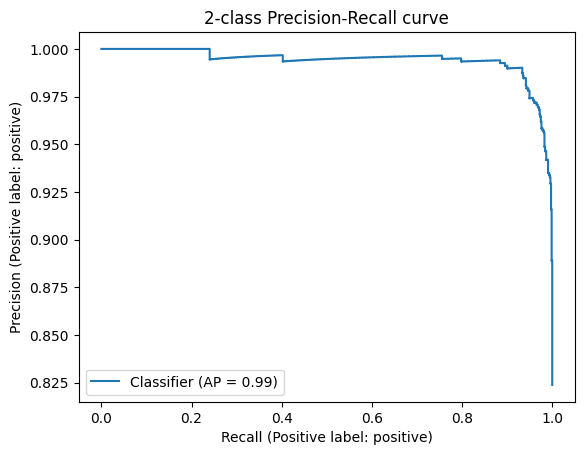

In [63]:
evaluate_embeddings_approach(labels=['negative', 'positive'], model=EMBEDDING_MODEL)

We can see that this classifier already performs extremely well. We used similarity embeddings, and the simplest possible label name. Let's try to improve on this by using more descriptive label names, and search embeddings.

              precision    recall  f1-score   support

    negative       1.00      0.82      0.90       161
    positive       0.96      1.00      0.98       753

    accuracy                           0.97       914
   macro avg       0.98      0.91      0.94       914
weighted avg       0.97      0.97      0.97       914



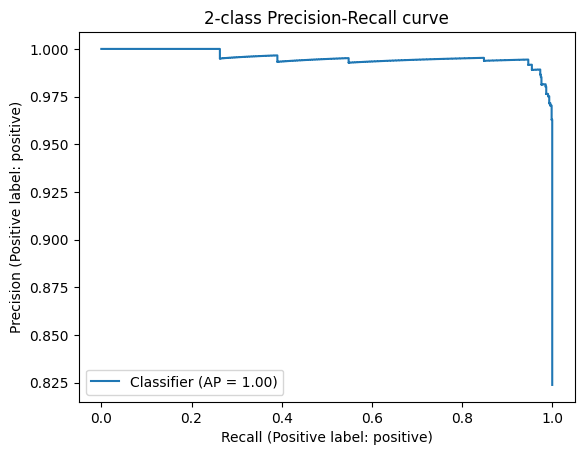

In [64]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])


Using the search embeddings and descriptive names leads to an additional improvement in performance.

              precision    recall  f1-score   support

    negative       1.00      0.82      0.90       161
    positive       0.96      1.00      0.98       753

    accuracy                           0.97       914
   macro avg       0.98      0.91      0.94       914
weighted avg       0.97      0.97      0.97       914



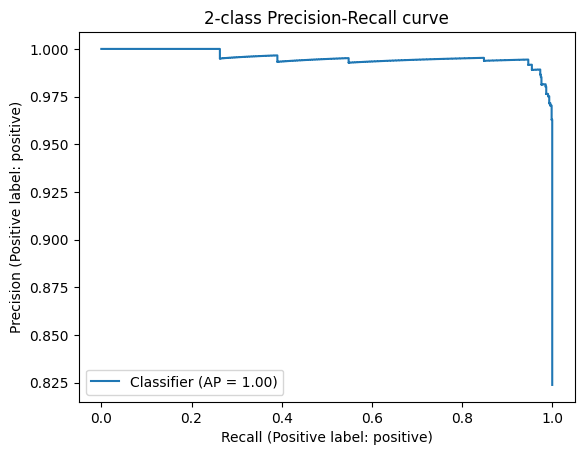

In [65]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])


As shown above, zero-shot classification with embeddings can lead to great results, especially when the labels are more descriptive than just simple words.

## Obtaining user and product embeddings for cold-start recommendation

We calculate user and product embeddings based on the training set, and evaluate the results on the unseen test set. We will evaluate the results by plotting the user and product similarity versus the review score. 

Skipped because the dataset is not available.


## Clustering

Clustering is one way of making sense of a large volume of textual data. Embeddings are useful for this task, as they provide semantically meaningful vector representations of each text. Thus, in an unsupervised way, clustering will uncover hidden groupings in our dataset.


In [99]:
import numpy as np
from sklearn.cluster import KMeans
from ast import literal_eval
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt



In [92]:
df = pd.read_csv('output/embedded_1k_reviews.csv')

df['ada_embedding'] = df.ada_embedding.apply(literal_eval).apply(np.array)

In [93]:
matrix = np.vstack(df.ada_embedding.values)
matrix.shape

(1000, 1536)

### Find the clusters using k-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [94]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)

/Users/arif/Documents/SourceCode/openai-dojo/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

In [95]:
labels = kmeans.labels_

In [96]:
labels

array([3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3,
       2, 0, 3, 2, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 1, 3,
       2, 3, 2, 1, 3, 3, 3, 3, 2, 0, 2, 1, 3, 3, 2, 3, 3, 3, 3, 1, 2, 3,
       2, 1, 2, 1, 3, 3, 1, 3, 1, 1, 3, 2, 1, 3, 3, 2, 3, 2, 1, 1, 0, 2,
       3, 3, 1, 2, 2, 3, 3, 0, 3, 3, 2, 1, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3,
       1, 3, 2, 3, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 3, 2, 1, 1, 0, 3, 2, 1,
       0, 3, 0, 3, 2, 2, 3, 1, 3, 1, 2, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3,
       3, 1, 1, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 2, 2, 2, 1, 2, 2, 1, 3,
       3, 2, 1, 0, 2, 3, 1, 2, 3, 2, 2, 3, 3, 2, 3, 1, 1, 0, 3, 3, 1, 3,
       3, 1, 3, 3, 1, 3, 3, 0, 2, 3, 3, 1, 0, 3, 2, 0, 1, 1, 3, 2, 3, 2,
       3, 3, 3, 3, 3, 2, 1, 2, 3, 2, 2, 3, 2, 1, 2, 3, 3, 2, 1, 3, 1, 1,
       3, 1, 1, 0, 2, 2, 0, 3, 3, 2, 3, 1, 3, 2, 1, 3, 1, 2, 2, 1, 2, 1,
       3, 3, 2, 2, 0, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 1,
       1, 0, 3, 0, 1, 3, 2, 3, 1, 3, 1, 2, 2, 2, 1,

In [97]:
df['Cluster'] = labels

In [98]:
df.groupby('Cluster').Score.mean().sort_values()

Cluster
2    4.096234
3    4.098361
1    4.184874
0    4.197917
Name: Score, dtype: float64

In [100]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [101]:
vis_dims2 = tsne.fit_transform(matrix)

In [102]:
vis_dims2

array([[-2.2046869e+01,  7.4843678e+00],
       [-4.8329895e+01, -2.2531837e-02],
       [ 9.7943573e+00, -2.9838589e+01],
       ...,
       [-7.0807976e+01, -2.0849476e+01],
       [ 7.5044308e+00, -4.6994900e+01],
       [ 1.4469770e+01,  6.4233826e+01]], dtype=float32)

In [103]:
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

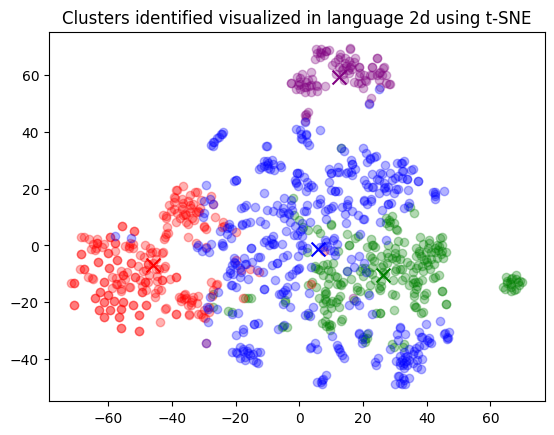

In [105]:
for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.title("Clusters identified visualized in language 2d using t-SNE")

### Text samples and naming the clusters

Let's show random samples from each cluster. We'll use  'gpt-4-1106-preview' to name the clusters, based on a random sample of 5 reviews from that cluster.

In [109]:
from openai import OpenAI

client = OpenAI()

In [107]:
# Reading a review which belong to each group.
review_per_cluster = 5

In [108]:
df.head(10)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,ada_embedding,Cluster
0,B0032GRU16,AGFEBA922M3IF,5,Good Energy,This energy drink has worked for me. I drink o...,Title: Good Energy; Content: This energy drink...,45,"[0.0029977525118738413, -0.012564492411911488,...",3
1,B004K30HO2,A1D8OFF2E5CPXD,5,a must for anyone who thinks K cups are too ex...,"I purchased these on a whim, and after researc...",Title: a must for anyone who thinks K cups are...,392,"[0.00040634378092363477, 0.0005885417340323329...",2
2,B0017T556M,A3IDROUQM8KBX8,5,Cinnamon Good,In my area one cannot find Cinnamon Mentos. I...,Title: Cinnamon Good; Content: In my area one ...,39,"[-0.010574543848633766, -0.0059465160593390465...",1
3,B004L54ST4,AHGHARSGT22DU,4,A winner in the iron category,I love the fact that this has so much iron in ...,Title: A winner in the iron category; Content:...,99,"[-0.005497496109455824, -0.025049692019820213,...",3
4,B001E5E29A,A318RRB7AV2TDC,5,Delicious and Easy,We have pancakes once a week and this is our g...,Title: Delicious and Easy; Content: We have pa...,80,"[0.002535681240260601, 0.008461098186671734, 0...",3
5,B003DKY5R8,A15S4QSK2MUKIN,5,Perfect for Dieters on a Hot Day,"I adore these K-Cups! On a keto diet, it can b...",Title: Perfect for Dieters on a Hot Day; Conte...,62,"[-0.0006557371816597879, -0.010052417404949665...",2
6,B002BRC562,A2HT2L7YLFM0BG,2,Tasty,These taste great! And it's true what other r...,Title: Tasty; Content: These taste great! And...,80,"[-0.020246634259819984, -0.023513073101639748,...",1
7,B00196497O,A2DL4D6SLDYBPA,5,Hemp Oil,"Our acupuncturist recommended this to us, to ...",Title: Hemp Oil; Content: Our acupuncturist re...,80,"[-0.015583539381623268, 0.01274416595697403, 0...",3
8,B001IZM8A6,A2ANZVA56T7RAG,5,Great product,I ordered this product at the same time as the...,Title: Great product; Content: I ordered this ...,82,"[0.008958798833191395, -0.006289090029895306, ...",3
9,B002G8N4ZW,A20S7XV2JK0UXL,4,Spray garlic!,It's a great product- especially if you like g...,Title: Spray garlic!; Content: It's a great pr...,77,"[0.0052045853808522224, 0.005791442468762398, ...",3


In [117]:
df.combined.head(10)

0    Title: Good Energy; Content: This energy drink...
1    Title: a must for anyone who thinks K cups are...
2    Title: Cinnamon Good; Content: In my area one ...
3    Title: A winner in the iron category; Content:...
4    Title: Delicious and Easy; Content: We have pa...
5    Title: Perfect for Dieters on a Hot Day; Conte...
6    Title: Tasty; Content: These taste great!  And...
7    Title: Hemp Oil; Content: Our acupuncturist re...
8    Title: Great product; Content: I ordered this ...
9    Title: Spray garlic!; Content: It's a great pr...
Name: combined, dtype: object

In [133]:
for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("; Content: ", ":  ")
        .sample(review_per_cluster, random_state=42)
        .values
    )

    # https://platform.openai.com/docs/guides/text-generation/chat-completions-api
    # https://platform.openai.com/docs/api-reference/chat
    response = client.chat.completions.create(
        model='gpt-4-1106-preview',
        messages=[
            {'role': 'system', 'content': 'You are tasked with finding common theme in customer reviews'},
            {'role': 'user', 'content': f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:'}
        ],
        temperature=0,
        max_tokens=64,
    )
    print(response.choices[0].message.content)

    sample_cluster_rows = df[df.Cluster == i].sample(review_per_cluster, random_state=42)
    for j in range(review_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)

print('finish.')


Cluster 0 Theme: The common theme in these customer reviews is pet care and pet products. Each review discusses a product that is intended for use by or for pets, such as dog food, bully sticks (a type of dog chew), and seeds likely for cat grass. The reviews focus on the quality, suitability, and benefits of these products
5, Why I like Newmans:   Excellent I needed a dog food without copper as an ingredient and foun
2, Small Diameter - Good for small dogs, not for our 44 lb dog.:   I ordered these despite my concerns after reading other reviews re: sm
4, Healthier:   I feel better about feeding this product to my dogs.  I was using anot
5, Natural, Grain Free and my Dogs love it:   My dogs love this food and with the limited ingredients and low allerg
5, THEY GROW EASY:   These seeds grow very easy, one seed pack grew about 7 little pots. I 
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The common theme in these 

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.

## Text search using embeddings

We can search through all our reviews semantically in a very efficient manner and at very low cost, by embedding our search query, and then finding the most similar reviews.

In [134]:
import pandas as pd
import numpy as np
from ast import literal_eval



In [137]:
datafile_path = 'output/embedded_1k_reviews.csv'

df = pd.read_csv(datafile_path)
df['ada_embedding'] = df.ada_embedding.apply(literal_eval).apply(np.array)

df.head(10)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,ada_embedding
0,B0032GRU16,AGFEBA922M3IF,5,Good Energy,This energy drink has worked for me. I drink o...,Title: Good Energy; Content: This energy drink...,45,"[0.0029977525118738413, -0.012564492411911488,..."
1,B004K30HO2,A1D8OFF2E5CPXD,5,a must for anyone who thinks K cups are too ex...,"I purchased these on a whim, and after researc...",Title: a must for anyone who thinks K cups are...,392,"[0.00040634378092363477, 0.0005885417340323329..."
2,B0017T556M,A3IDROUQM8KBX8,5,Cinnamon Good,In my area one cannot find Cinnamon Mentos. I...,Title: Cinnamon Good; Content: In my area one ...,39,"[-0.010574543848633766, -0.0059465160593390465..."
3,B004L54ST4,AHGHARSGT22DU,4,A winner in the iron category,I love the fact that this has so much iron in ...,Title: A winner in the iron category; Content:...,99,"[-0.005497496109455824, -0.025049692019820213,..."
4,B001E5E29A,A318RRB7AV2TDC,5,Delicious and Easy,We have pancakes once a week and this is our g...,Title: Delicious and Easy; Content: We have pa...,80,"[0.002535681240260601, 0.008461098186671734, 0..."
5,B003DKY5R8,A15S4QSK2MUKIN,5,Perfect for Dieters on a Hot Day,"I adore these K-Cups! On a keto diet, it can b...",Title: Perfect for Dieters on a Hot Day; Conte...,62,"[-0.0006557371816597879, -0.010052417404949665..."
6,B002BRC562,A2HT2L7YLFM0BG,2,Tasty,These taste great! And it's true what other r...,Title: Tasty; Content: These taste great! And...,80,"[-0.020246634259819984, -0.023513073101639748,..."
7,B00196497O,A2DL4D6SLDYBPA,5,Hemp Oil,"Our acupuncturist recommended this to us, to ...",Title: Hemp Oil; Content: Our acupuncturist re...,80,"[-0.015583539381623268, 0.01274416595697403, 0..."
8,B001IZM8A6,A2ANZVA56T7RAG,5,Great product,I ordered this product at the same time as the...,Title: Great product; Content: I ordered this ...,82,"[0.008958798833191395, -0.006289090029895306, ..."
9,B002G8N4ZW,A20S7XV2JK0UXL,4,Spray garlic!,It's a great product- especially if you like g...,Title: Spray garlic!; Content: It's a great pr...,77,"[0.0052045853808522224, 0.005791442468762398, ..."


Here we compare the cosine similarity of the embeddings of the query and the documents, and show top_n best matches.

In [136]:
# https://learn.microsoft.com/en-us/azure/ai-services/openai/tutorials/embeddings?tabs=python-new%2Ccommand-line

def cosine_similary(a, b):
    return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model=EMBEDDING_MODEL):
    return client.embeddings.create(
        input=[text],
        model=model
    ).data[0].embedding


In [138]:
# search through the reviews for a specific product

def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(product_description, model=EMBEDDING_MODEL)
    df['similarity'] = df.ada_embedding.apply(lambda x: cosine_similary(x, product_embedding))

    results = (
        df.sort_values('similarity', ascending=False)
            .head(n)
            .combined.str.replace("Title: ", "")
            .str.replace("; Content:", ": ")
    )

    if pprint:
        for r in results:
            print(r[:200])
            print()
    
    return results

In [141]:
results = search_reviews(df, 'delicious beans', n=3)

Goes great with black beans and rice!:  I combine this with Libby's Organic Black Beans and Libby's Organic Green Beans mixed with Bob's Red Mill Organic Brown Rice at least two or three times per wee

Great Value:  Got 58 beans in the 1/2 lbs package which is a great value. They are moist so they are super fresh. Great Find.

these beans were wonderful:  i have started the extraction process less than a month ago, and so far it looks and smell wonderful. waiting to try it.i have put 6 oz in 1.75 liters of vodka and now hav



In [142]:
results = search_reviews(df, 'whole weat pasta', n=3)

reminds me of Italy:  I rarely eat anything but whole wheat pasta, but every once in a while, I eat some of this as a treat.  Almost as good as the pastas that I ate while in Italy!  Just make sure yo

Real Pasta With Half the Calories and Most of the Taste!:  Just a quick note... a very good friend of mine who also battles weight issues and love pasta turned me on to this product.  We bought a box 

Great Pasta:  Love this pasta.  I mix this with regular pasta for a meal, half and half.  Love the lower calories and the fiber content.



We can search through these reviews easily. To speed up computation, we can use a special algorithm, aimed at faster search through embeddings.

In [143]:
results = search_reviews(df, "bad delivery", n=1)


Extremely dissapointed:  Hi,<br />I am very disappointed with the past shipment I received of the ONE coconut water. 3 of the boxes were leaking and the coconut water was spoiled.<br /><br />Thanks.<b



As we can see, this can immediately deliver a lot of value. In this example we show being able to quickly find the examples of delivery failures.

In [144]:
results = search_reviews(df, "spoilt", n=1)


Extremely dissapointed:  Hi,<br />I am very disappointed with the past shipment I received of the ONE coconut water. 3 of the boxes were leaking and the coconut water was spoiled.<br /><br />Thanks.<b



In [145]:
results = search_reviews(df, "pet food", n=2)


GOOD CAT FOOD:  My cats really love this 9 Lives Seafood and Poultry cat food.<br />They prefer this pate to the slices or chunks.<br />They are a perfect weight and have beautiful shiny coats<br />an

It's cat food, they eat it, seems pretty healthy:  The cats like this stuff pretty well, for the health of our felines we keep them on an all-canned food diet. This is one of their favorite flavors, I



## Recommendations using embeddings

Because shorter distances between embedding vectors represent greater similarity, embeddings can be useful for recommendation.

Recommendations are widespread across the web.

- 'Bought that item? Try these similar items.'
- 'Enjoy that book? Try these similar titles.'
- 'Not the help page you were looking for? Try these similar pages.'

This notebook demonstrates how to use embeddings to find similar items to recommend. In particular, we use AG's corpus of news articles as our dataset.

Our model will answer the question: given an article, what other articles are most similar to it?


In [159]:
import pandas as pd
import pickle
from scipy import spatial
from sklearn.manifold import TSNE
import plotly.express as px

from typing import List, Optional

## helper methods
https://github.com/openai/openai-python/blob/870534d39cb4a37a696efc2507cc1e89e18e6a07/openai/embeddings_utils.py#L139


In [162]:
def cosine_similary(a, b):
    return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model=EMBEDDING_MODEL):
    return client.embeddings.create(
        input=[text],
        model=model
    ).data[0].embedding

def distances_from_embeddings(
    query_embedding: List[float],
    embeddings: List[List[float]],
    distance_metric: 'cosine'
) -> List[List]:
    distance_metrics = {
        'cosine': spatial.distance.cosine,
        'L1': spatial.distance.cityblock,
        'L2': spatial.distance.euclidean,
        'Linf': spatial.distance.chebyshev
    }

    distances = [
        distance_metrics[distance_metric](query_embedding, embedding)
        for embedding in embeddings
    ]

    return distances

def tsne_components_from_embeddings(
    embeddings: List[List[float]],
    n_components=2, 
    **kwargs
) -> np.ndarray:
    """Returns t-SNE components of a list of embeddings"""

    # use better defaults if not specified
    if 'init' not in kwargs.keys():
        kwargs['init'] = 'pca'

    if 'learning_rate' not in kwargs.keys():
        kwargs['learning_rate'] = 'auto'

    tsne = TSNE(n_components=n_components, **kwargs)
    array_of_embeddings = np.array(embeddings)

    return tsne.fit_transform(array_of_embeddings)


def chart_from_components(
    components: np.ndarray,
    labels: Optional[List[str]] = None,
    strings: Optional[List[str]] = None,
    x_title='Component 0',
    y_title='component 1',
    mark_size=5,
    **kwargs
):
    """Return an interactive 2D chart of embedding components."""
    
    empty_list = ['' for _ in components]
    data = pd.DataFrame(
        {
            x_title: components[:, 0],
            y_title: components[:, 1],
            "label": labels if labels else empty_list,
            "string": ["<br>".join(tr.wrap(string, width=30)) for string in strings]
                if strings
                else empty_list,
        }
    )
    
    chart = px.scatter(
        data,
        x=x_title,
        y=y_title,
        color="label" if labels else None,
        symbol="label" if labels else None,
        hover_data=["string"] if strings else None,
        **kwargs,
    ).update_traces(marker=dict(size=mark_size))

    return chart


def indices_of_nearest_neighbors_from_distances(distances) -> np.ndarray:
    """Return a list of indices of nearest neighbors from a list of distances."""
    return np.argsort(distances)

In [163]:
dataset_path = 'archive/AG_news_samples.csv'

df = pd.read_csv(dataset_path)


In [164]:
df.head(10)

,title,description,label_int,label
0,World Briefings,BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime M...,1,World
1,Nvidia Puts a Firewall on a Motherboard (PC Wo...,PC World - Upcoming chip set will include buil...,4,Sci/Tech
2,"Olympic joy in Greek, Chinese press",Newspapers in Greece reflect a mixture of exhi...,2,Sports
3,U2 Can iPod with Pictures,"SAN JOSE, Calif. -- Apple Computer (Quote, Cha...",4,Sci/Tech
4,The Dream Factory,"Any product, any shape, any size -- manufactur...",4,Sci/Tech
5,"Fierce clashes kill three US soldiers, injure ...","KABUL, Sept 22 (AFP): Three US soldiers were k...",1,World
6,US-EU talks on Airbus subsidies fail,The EU and US moved closer to an aviation trad...,3,Business
7,Aussie alive after capture in Iraq,AUSTRALIAN journalist John Martinkus is lucky ...,1,World
8,Israeli Helicopter Fires Missile in Gaza -Witn...,GAZA (Reuters) - An Israeli helicopter fired ...,1,World
9,Ballmer: We need a \$100 PC,The Microsoft CEO says one way to stem growing...,4,Sci/Tech


In [166]:
for idx, row in df.head(10).iterrows():
    print("")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Label: {row['label']}")


Title: World Briefings
Description: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
Label: World

Title: Nvidia Puts a Firewall on a Motherboard (PC World)
Description: PC World - Upcoming chip set will include built-in security features for your PC.
Label: Sci/Tech

Title: Olympic joy in Greek, Chinese press
Description: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
Label: Sports

Title: U2 Can iPod with Pictures
Description: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
Label: Sci/Tech

Title: The Dream Factory
Description: Any product, any shape, any size -- manufactured o

### Build cache to save embeddings

Before getting embeddings for these articles, let's set up a cache to save the embeddings we generate. In general, it's a good idea to save your embeddings so you can re-use them later. If you don't save them, you'll pay again each time you compute them again.

The cache is a dictionary that maps tuples of (text, model) to an embedding, which is a list of floats. The cache is saved as a Python pickle file.

In [185]:
embedding_cache_path = 'output/recommendations_embeddings_cache.pkl'

try:
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}

with open(embedding_cache_path, 'wb') as embedding_cache_file:
    pickle.dump(embedding_cache, embedding_cache_file)

define a function to retrieve embeddings from the cache if present, and otherwise request via the API

In [182]:
def embedding_from_string(
    string: str,
    model: str = EMBEDDING_MODEL,
    embedding_cache=embedding_cache
) -> List:
    """Return embedding of given string, using a cache to avoid recomputing."""
    print(f'- Embedding from string: {string}')

    if (string, model) not in embedding_cache.keys():
        embedding_cache[(string, model)] = get_embedding(string, model=model)
        with open(embedding_cache_path, 'wb') as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    
    return embedding_cache[(string, model)] 

Let's check that it works by getting an embedding.

In [170]:
example_string = df['description'].values[0]
print(f'Example string:\n {example_string}')

Example string:
 BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.


Print the first 10 dimensions of the embedding

In [171]:
example_embedding = embedding_from_string(example_string)

In [172]:
print(f'Example embedding: {example_embedding[:10]}')

Example embedding: [-0.010669779032468796, -0.02238333970308304, -0.008827051147818565, -0.02538582682609558, 0.03136502578854561, 0.010766425170004368, -0.01677783951163292, 0.004291106481105089, -0.007989447563886642, -0.02144264616072178]


### Recommend similar articles based on embeddings

To find similar articles, let's follow a three-step plan:

1. Get the similarity embeddings of all the article descriptions
2. Calculate the distance between a source title and all other articles
3. Print out the other articles closest to the source title

In [189]:
def print_recommendations_from_strings(
    strings: List[str],
    index_of_source_string: int,
    knn: int = 1,
    model=EMBEDDING_MODEL 
) -> List[int]:
    """Print out the k nearest neighbors of a given string."""
    
    print(f'Strings size: {len(strings)}')
    print('Get the embeddings...')
    embeddings = [embedding_from_string(string, model) for string in strings]
    
    # get the embedding of the source string
    query_embedding = embeddings[index_of_source_string]
    # get distances between the source embedding and other embeddings (function from utils.embeddings_utils.py)
    distances = distances_from_embeddings(query_embedding, embeddings, distance_metric='cosine')
    # get indices of nearest neighbors 
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances)

    # print out source string
    query_string = strings[index_of_source_string]
    print(f"Source string: {query_string}")

    # print out its k nearest neighbors
    k_counter = 0
    for i in indices_of_nearest_neighbors:
        # skip any strings that are identical matches to the starting string
        if query_string == strings[i]:
            continue
        # stop after printing k articles
        if k_counter >= knn:
            break
        k_counter += 1

        # print out the similar strings and their distances
        print(
            f"""
        --- Recommendation #{k_counter} (nearest neighbor {k_counter} of {knn}) ---
        String: {strings[i]}
        Distance: {distances[i]:0.3f}"""
        )

    return indices_of_nearest_neighbors

### Example recommendations

In [183]:
article_descriptions = df['description'].tolist()

article_descriptions

['BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.',
 'PC World - Upcoming chip set will include built-in security features for your PC.',
 'Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.',
 'SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.',
 'Any product, any shape, any size -- manufactured on your desktop! The future is the fabricator. By Bruce Sterling from Wired magazine.',
 'KABUL, Sept 22 (AFP): Three US soldiers were killed and 14 wounded in a series of fierce clashes with suspected Taliban fighters in south and eastern Afghanistan this week, the US military said Wednesday.

In [190]:
tony_blair_articles = print_recommendations_from_strings(
    strings=article_descriptions,
    index_of_source_string=0,
    knn=5
)

Strings size: 2000
Get the embeddings...
- Embedding from string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
- Embedding from string: PC World - Upcoming chip set will include built-in security features for your PC.
- Embedding from string: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
- Embedding from string: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
- Embedding from string: Any product, any shape, any size -- manufactured on your desktop! The future is the fabricator. By Bruce Sterling from Wired magazine.
- Embedding from string: KABUL, Sept 22 (AFP): Three US sold